<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Разреженные данные, онлайн-обучение</center>

## <center>Часть 1. Категориальные признаки</center>

### <center>One-hot encoding</center>

Подавляющее большинство методов классификации и регрессии сформулированы в терминах евклидовых или метрических пространств, то есть подразумевают представление данных в виде вещественных векторов одинаковой размерности. В реальных данных, однако, не так редки категориальные атрибуты, принимающие дискретные значения, такие как да/нет или  январь/февраль/.../декабрь. В ходе этого занятия мы научимся работать с такими данными, в частности с помощью линейных моделей.

In [1]:
import pandas as pd

import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
import sklearn.preprocessing
import sklearn.feature_extraction

%matplotlib inline

import matplotlib.pyplot as plt
from pprint import pformat
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

В этой части занятия мы рассмотрим выборку bank:

In [2]:
df = pd.read_csv('../../data/bank_train.csv')
labels = pd.read_csv('../../data/bank_train_target.csv', header=None)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Нетрудно заметить, что достаточно много признаков в этом наборе данных не представлены числами. В таком виде данные еще нам не подходят - мы не сможем применять подавляющее большинство доступных нам методов.

Чтобы найти решение, давайте рассмотрим атрибут education:

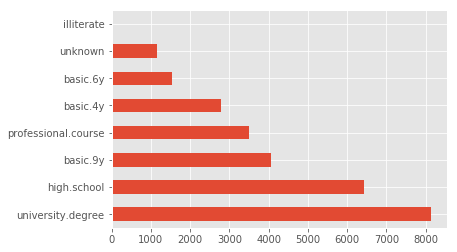

In [3]:
df['education'].value_counts().plot.barh();

Естественным решением такой проблемы было бы однозначное отображение каждого значения в уникальное число. К примеру, мы могли бы преобразовать university.degree в 0, а basic.9y в 1. Эту простую операцию приходится делать часто, поэтому в модуле preprocessing библиотеки sklearn именно для этой задачи реализован класс LabelEncoder:

In [4]:
label_encoder = sklearn.preprocessing.LabelEncoder()

Метод fit этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes, содержащее все уникальные значения. Пронумеруем их, чтобы убедиться, что преобразование выполнено верно. 

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


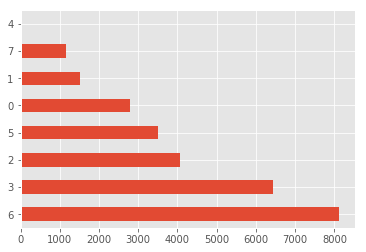

In [5]:
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

Что произойдет, если у нас появятся данные с другими категориями?

In [6]:
try:
    label_encoder.transform(df['education'].replace('high.school', 'high_school'))
except Exception as e:
    print('Error:', e)

Error: y contains new labels: ['high_school']


Таким образом, при использовании этого подхода мы всегда должны быть уверены, что признак не может принимать неизвестных ранее значений. К этой проблеме мы вернемся чуть позже, а сейчас заменим весь столбец education на преобразованный:

In [7]:
df['education'] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Продолжим преобразование для всех столбцов, имеющих тип object - именно этот тип задается в pandas для таких данных.

In [8]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


Основная проблема такого представления заключается в том, что числовой код создал евклидово представление для данных.

К примеру, нами неявным образом была введена алгебра над значениями работы - мы можем вычесть работу клиента 1 из работы клиента 2:

In [12]:
df.loc[1].job - df.loc[2].job

-1.0

Конечно же, эта операция не имеет никакого смысла. Но именно на этом основаны метрики близости объектов, что делает бессмысленным применение метода ближайшего соседа на данных в таком виде. Аналогичным образом, никакого смысла не будет иметь применение линейных моделей. Убедимся в этом:

In [13]:
!pip install -U scikit-learn

  Found existing installation: scikit-learn 0.18.1
    Uninstalling scikit-learn-0.18.1:


    DEPRECATION: Uninstalling a distutils installed project (scikit-learn) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.
Exception:
Traceback (most recent call last):
  File "C:\Program Files\Anaconda3\lib\shutil.py", line 544, in move
    os.rename(src, real_dst)
PermissionError: [WinError 5] Отказано в доступе: 'c:\\program files\\anaconda3\\lib\\site-packages\\scikit_learn-0.18.1-py3.6.egg-info' -> 'C:\\Users\\USR\\AppData\\Local\\Temp\\pip-ahork5kx-uninstall\\program files\\anaconda3\\lib\\site-packages\\scikit_learn-0.18.1-py3.6.egg-info'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Program Files\Anaconda3\lib\site-packages\pip\basecommand.py", line 215, in main
    status = self.run(options, args)
  File "C:\Program Files\Anaconda3\lib\site-packages\pip\commands\install.py", line 342, in run


In [9]:
import sklearn
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.as_matrix()
    train_features, test_features, train_labels, test_labels = \
        sklearn.cross_validation.train_test_split(features, labels)

    lr = sklearn.linear_model.LogisticRegression()
    lr.fit(train_features, train_labels)
    return sklearn.metrics.classification_report(test_labels, lr.predict(test_features))

print(logistic_regression_accuracy_on(df[categorical_columns], labels))

AttributeError: module 'sklearn' has no attribute 'cross_validation'

Для того, чтобы мы смогли применять линейные модели на таких данных нам необходим другой метод, который называется one-hot encoding.

Предположим, что некоторый признак может принимать 10 разных значений. В этом случае one hot encoding подразумевает создание 10 признаков, все из которых равны нулю *за исключением одного*. На позицию, соответствующую численному значению признака мы помещаем 1:

In [10]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


Эта техника реализована в sklearn в классе OneHotEncoder. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей. Однако в этом примере размер данных не является для нас проблемой, поэтому мы будем использовать "плотное" представление.

In [11]:
onehot_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)

Преобразуем категориальные столбцы с помощью OneHotEncoder:

In [12]:
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Мы получили 53 столбца - именно столько различных уникальных значений могут принимать категориальные столбцы исходной выборки. Преобразованные с помощью one-hot encoding данные начинают обретать смысл для линейной модели:

In [13]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

AttributeError: module 'sklearn' has no attribute 'cross_validation'

### <center>Hashing trick</center>

Реальные данные могут оказаться гораздо более динамичными и мы не всегда можем рассчитывать, что категориальные признаки не будут принимать новых значений. Все это сильно затрудняет использование уже обученных моделей на новых данных. Кроме того, LabelEncoder подразумевает предварительный анализ всей выборки и хранение построенных отображений в памяти, что затрудняет работу в режиме больших данных.

Для решения этих проблем существует более простой подход к векторизации категориальных признаков, основанный на хэшировании, известный как hashing trick. 

Хэш-функции могут помочь нам в задаче поиска уникальных кодов для различных значений атрибутов, к примеру:

In [14]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s))

university.degree -> -5218409209100774569
high.school -> -6050960430439890459
illiterate -> 3266682448790849908


Отрицательные и настолько большие по модулю значения нам не подойдут. Ограничим область значений хэш-функции:

In [15]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 6
high.school -> 16
illiterate -> 8


Представим, что у нас в выборке есть холостой студент, которому позвонили в понедельник, тогда его вектор признаков будет сформирован аналогично one-hot encoding, но в **едином пространстве фиксированного размера для всех признаков**:

In [16]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 0
marital=single -> 19
day_of_week=mon -> 23


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Стоит обратить внимание, что в этом примере хэшировались не только значения атрибутов, а **пары название атрибута + значение атрибута**. Это необходимо, чтобы разделить одинаковые значения разных атрибутов между собой, к примеру:

In [17]:
assert hash('no') == hash('no')
assert hash('housing=no') != hash('loan=no')

Может ли произойти коллизия хэш-функции, то есть совпадение кодов для двух разных значений? Нетрудно доказать, что при достаточном размере пространства хэширования это происходит редко, но даже в тех случаях, когда это происходит, это не будет приводить к существенному ухудшению качества классификации или регрессии.

В следующей части занятия мы будем применять подход на основе хэширования для работы с категориальными данными.